In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)


In [19]:
df = pd.read_csv("../data/raw/T1.csv")


Inspect the data structure to check the number of records, column names, data types and missing values

In [ ]:
df.shape # Check the number of records and features
df.head() # Display the first few records
df.tail() # Display the last few records
df.info() # Check for missing values and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [ ]:
df.columns # List all column names


Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')

In [28]:
df.isna().sum() # Count missing values in each column

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [15]:
df["Date/Time"].head(10)


0    01 01 2018 00:00
1    01 01 2018 00:10
2    01 01 2018 00:20
3    01 01 2018 00:30
4    01 01 2018 00:40
5    01 01 2018 00:50
6    01 01 2018 01:00
7    01 01 2018 01:10
8    01 01 2018 01:20
9    01 01 2018 01:30
Name: Date/Time, dtype: object

In [27]:
df["Date/Time"].sample(10, random_state=42)


8057    2018-03-02 10:40:00
8059    2018-03-02 11:00:00
50250   2018-12-30 01:20:00
14774   2018-04-18 04:50:00
49374   2018-12-23 23:20:00
22716   2018-06-12 17:30:00
26364   2018-07-08 07:30:00
49234   2018-12-23 00:00:00
11993   2018-03-29 18:50:00
15125   2018-04-20 15:20:00
Name: Date/Time, dtype: datetime64[ns]

In [26]:
# Try parsing mixed formats robustly
dt = pd.to_datetime(df["Date/Time"], errors="coerce", dayfirst=True)

# How many failed to parse?
failed = dt.isna().sum()
print("Unparseable datetime rows:", failed)

# Assign back + sort
df["Date/Time"] = dt
df = df.dropna(subset=["Date/Time"]).sort_values("Date/Time").reset_index(drop=True)


Unparseable datetime rows: 0


In [24]:
df["Date/Time"].min(), df["Date/Time"].max() # Check time range


('01 01 2018 00:00', '31 12 2018 23:50')

In [29]:
df["Date/Time"].diff().value_counts().head(10) # Check time differences between records


Date/Time
0 days 00:10:00    50497
0 days 00:20:00       11
0 days 00:40:00        2
0 days 03:00:00        1
4 days 08:20:00        1
0 days 00:50:00        1
0 days 01:40:00        1
0 days 01:00:00        1
0 days 02:10:00        1
0 days 06:30:00        1
Name: count, dtype: int64

In [20]:
df["Date/Time"].duplicated().sum() # Check for duplicate timestamps


np.int64(0)

In [30]:
delta_counts = df["Date/Time"].diff().value_counts()
most_common_delta = delta_counts.index[0]
print("Most common sampling interval:", most_common_delta)

gaps = df["Date/Time"].diff() > most_common_delta
print("Number of gaps larger than expected:", gaps.sum())

df.loc[gaps, ["Date/Time"]].head()


Most common sampling interval: 0 days 00:10:00
Number of gaps larger than expected: 32


,Date/Time
491,2018-01-04 12:40:00
768,2018-01-06 11:30:00
1577,2018-01-12 02:30:00
3617,2018-01-30 14:40:00
9188,2018-03-10 07:20:00


# 3 — Final Time-Series Conclusions
Temporal Characteristics

The SCADA data is predominantly sampled at 10-minute intervals, consistent with standard industrial wind turbine monitoring.
A small number of larger time gaps were observed, likely corresponding to turbine downtime, maintenance activities, or communication outages.
These gaps are retained at this stage to preserve the authenticity of the operational timeline and will be handled explicitly during preprocessing.

In [31]:
df["Date/Time"] = pd.to_datetime(df["Date/Time"])
df = df.sort_values("Date/Time")
df = df.reset_index(drop=True)


Visual inspection of key signals

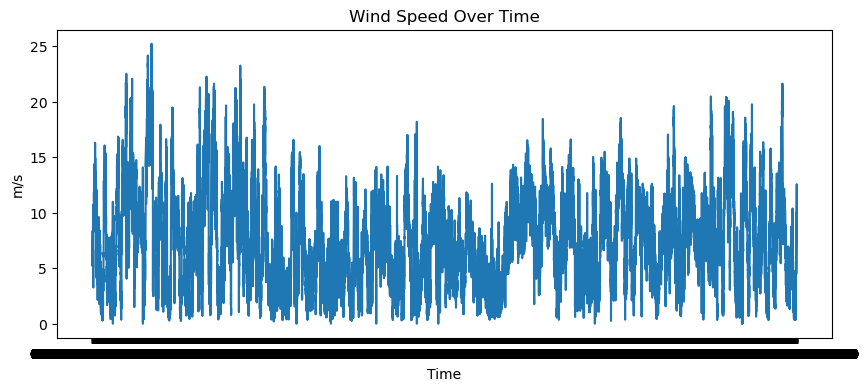

In [7]:
# Wind speed over time plot
plt.figure(figsize=(10,4))
plt.plot(df["Date/Time"], df["Wind Speed (m/s)"])
plt.title("Wind Speed Over Time")
plt.xlabel("Time")
plt.ylabel("m/s")
plt.show()


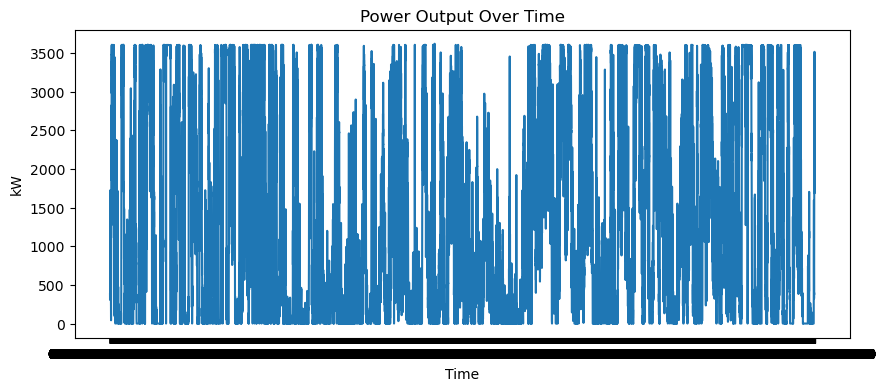

In [10]:
# Power output over time plot
plt.figure(figsize=(10,4))
plt.plot(df["Date/Time"], df["LV ActivePower (kW)"])
plt.title("Power Output Over Time")
plt.xlabel("Time")
plt.ylabel("kW")
plt.show()


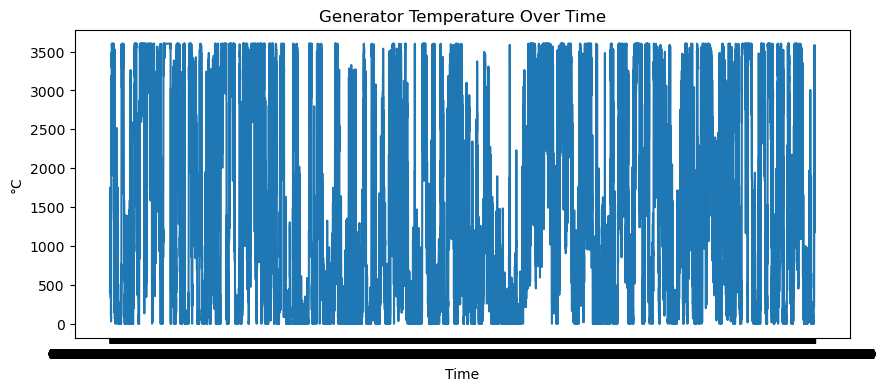

In [13]:
# Generator temperature over time plot
plt.figure(figsize=(10,4))
plt.plot(df["Date/Time"], df["Theoretical_Power_Curve (KWh)"])
plt.title("Generator Temperature Over Time")
plt.xlabel("Time")
plt.ylabel("°C")
plt.show()


# Step 4 — Finalised Assumptions & Constraints

Most data points represent normal turbine operation.

The 10-minute sampling frequency is sufficient to capture gradual fault development.

Short-term fluctuations are expected due to environmental variability.

Extended time gaps correspond to non-operational periods rather than sensor corruption.

Constraints (Final)

No labelled failure events or maintenance annotations are available.

Time gaps introduce irregular sampling that must be addressed before modelling.

Environmental variables may obscure fault-related patterns.

Results represent risk indicators, not definitive failure diagnoses.

# 5 - Data cleaning & signal condition
This is to convert the SCADA logs into a meaningful and consistent dataset suitable for anomaly detection

## 5.1 - Create a clean working xopy
This allows for safe experimentation and ensures reproducibility

In [32]:
df_clean = df.copy()

## 5.2 - Remove non operational times (idle states)
This would be identifying non-operational conditions such as when the wind speed and active power are 0


### 5.2.1 - Identify non-operational conditions 

In [8]:
non_operational = (
    (df_clean["Wind Speed (m/s)"] <= 0) |
    (df_clean["LV ActivePower (kW)"] <= 0)
)

non_operational.sum()


np.int64(10838)

### 5.2.2 - Remove them
Zero power does not mean there is fault. 
Including idle states would cause false anomalies

In [9]:
df_clean = df_clean.loc[~non_operational].reset_index(drop=True)


# 6A — Statistical Baseline Anomaly Detection
Objective

Detect abnormal turbine behaviour by identifying deviations from expected physical relationships, without machine learning.

## 6A.1 Why a Statistical Baseline?

Rationale for Statistical Baseline

Before applying machine learning, a statistical baseline is established to identify anomalies using interpretable, physics-informed metrics.
This provides transparency, reduces overfitting risk, and establishes a benchmark for evaluating more complex models.

## 6A.2 Core Idea: Power Residuals

Theoretical power already encodes turbine physics.

We compute:

Residual = Actual Power−Theoretical Power
Residual = Actual Power−Theoretical Power

Large negative residuals → turbine underperforming → potential fault

## 6A.3 Compute Power Residuals

In [44]:
df_stat = df_clean.copy()

df_stat["power_residual"] = (
    df_stat["LV ActivePower (kW)"]
    - df_stat["Theoretical_Power_Curve (KWh)"]
)


In [45]:
# Sanity check: power_residual stats
df_stat["power_residual"].describe()


count    50530.000000
mean      -184.491131
std        427.701555
min      -3600.000000
25%       -194.562692
50%        -66.682623
75%          0.000000
max        598.741011
Name: power_residual, dtype: float64

## 6A.4 Visualise Residuals Over Time

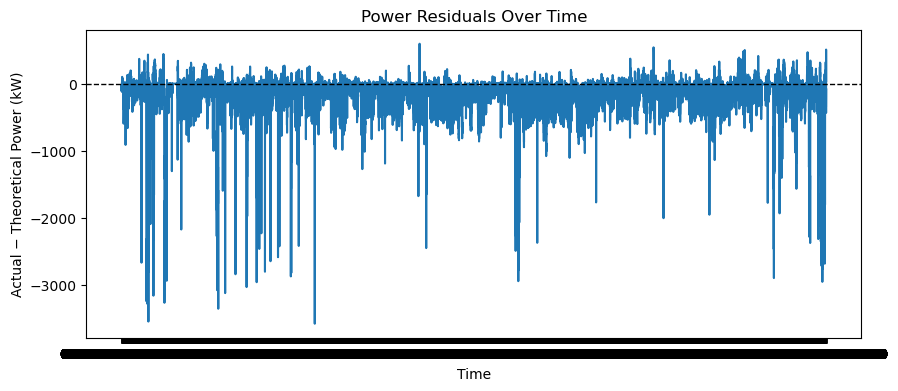

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(df_stat["Date/Time"], df_stat["power_residual"])
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Power Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Actual − Theoretical Power (kW)")
plt.show()


Values near Zero is what we expect, sustained(consistent) negative values indicates degradation while sudden large deviations shows potential fault events.

## 6A.5 Standardise Residuals (Z-score)

In [46]:
residual_mean = df_stat["power_residual"].mean()
residual_std = df_stat["power_residual"].std()

df_stat["residual_zscore"] = (
    (df_stat["power_residual"] - residual_mean) / residual_std
)

# check for distribution of z-scores
df_stat

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),power_residual,residual_zscore
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,-36.281117,0.346527
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,-66.148316,0.276695
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,-84.523429,0.233732
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,-96.481664,0.205773
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,-111.052276,0.171706
...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,-433.209835,-0.581524
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,511.297256,1.626808
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,412.822178,1.396566
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,97.311588,0.658877


## 6A.6 Define Anomaly Threshold
Industry-standard starting point:

|z| > 3 → strong anomaly

|z| > 2.5 → moderate anomaly

In [47]:
threshold = 3

df_stat["stat_anomaly"] = (
    df_stat["residual_zscore"].abs() > threshold
)

# count anomalies detected
df_stat["stat_anomaly"].sum()

np.int64(1249)

## 6A.7 Visualise Detected Anomalies

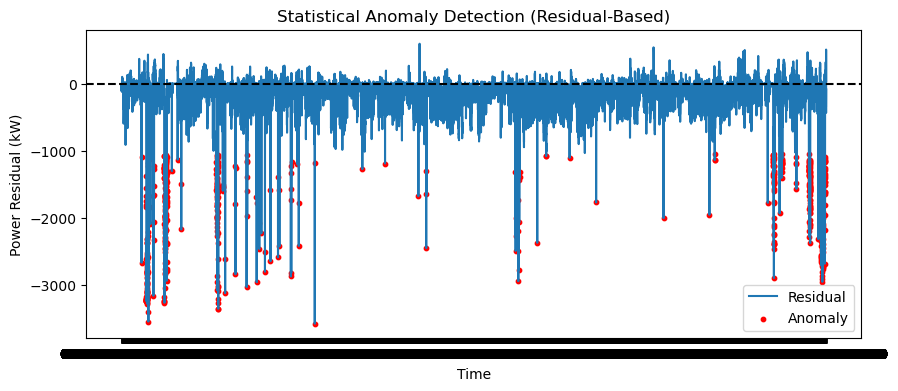

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(df_stat["Date/Time"], df_stat["power_residual"], label="Residual")

plt.scatter(
    df_stat.loc[df_stat["stat_anomaly"], "Date/Time"],
    df_stat.loc[df_stat["stat_anomaly"], "power_residual"],
    color="red",
    s=10,
    label="Anomaly"
)

plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.title("Statistical Anomaly Detection (Residual-Based)")
plt.xlabel("Time")
plt.ylabel("Power Residual (kW)")
plt.show()


## 6A.8 Interpret the Results

### Statistical Anomaly Interpretation

Anomalies identified using residual-based Z-scores correspond to periods where actual power output deviates significantly from expected theoretical performance.
Sustained negative residuals may indicate aerodynamic inefficiencies, mechanical degradation, or control system issues, while isolated spikes may reflect transient disturbances.

## 6A.9 Limitations of Statistical Baseline

### Limitations

The statistical baseline assumes a stationary residual distribution and does not account for multivariate interactions between sensors.
It may fail to detect subtle or gradual anomalies that do not strongly affect power output alone, motivating the use of machine learning–based methods in subsequent steps.

# 6B — ML-Based Anomaly Detection
This is to detect anomalies using unsupervised learning Machine learning models and then compare it with the statistical baseline.

## 6B.1 Why ML After a Statistical Baseline?
Statistical analysis relies on a single physical relationship while Machine Learning enables joint analysis of multiple variables (sensor signals) and can capture complex non-linear deviations from normal operating behaviour. 

## 6B.2 Feature Matrix for ML


In [34]:
features = [
    "Wind Speed (m/s)",
    "LV ActivePower (kW)",
    "Theoretical_Power_Curve (KWh)",
    "Wind Direction (°)"
]

X = df_clean[features]


## 6B.3 Scale Features
Isolation Forest is distance-agnostic, but scaling is still best practice for comparability and future models.

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 6B.4 Train Isolation Forest
It is widely used in industry anomaly detection. 
It is an unsupervised method and it is robust to outliers 

In [36]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.01,      # assume ~1% anomalies
    random_state=42
)

iso_forest.fit(X_scaled)


IsolationForest(contamination=0.01, n_estimators=200, random_state=42)

## 6B.5 Generate Anomaly Predictions
solation Forest outputs:

1 → normal

-1 → anomaly

In [38]:
df_ml = df_clean.copy()

df_ml["iforest_score"] = iso_forest.decision_function(X_scaled)
df_ml["iforest_anomaly"] = iso_forest.predict(X_scaled)


In [ ]:
# convert to boolean
df_ml["iforest_anomaly"] = df_ml["iforest_anomaly"] == -1


np.int64(506)

In [ ]:
# check counts
df_ml["iforest_anomaly"].value_counts()

iforest_anomaly
False    50024
True       506
Name: count, dtype: int64

## 6B.6 Visualise ML Anomalies Over Time

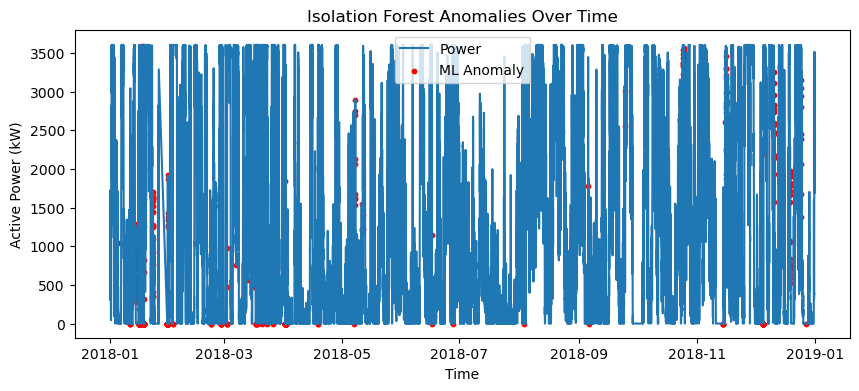

In [42]:
plt.figure(figsize=(10, 4))
plt.plot(df_ml["Date/Time"], df_ml["LV ActivePower (kW)"], label="Power")

plt.scatter(
    df_ml.loc[df_ml["iforest_anomaly"], "Date/Time"],
    df_ml.loc[df_ml["iforest_anomaly"], "LV ActivePower (kW)"],
    color="red",
    s=10,
    label="ML Anomaly"
)

plt.title("Isolation Forest Anomalies Over Time")
plt.xlabel("Time")
plt.ylabel("Active Power (kW)")
plt.legend()
plt.show()


## 6B.7 Compare ML vs Statistical Anomalies

In [48]:
df_compare = df_stat[["Date/Time", "stat_anomaly"]].merge(
    df_ml[["Date/Time", "iforest_anomaly"]],
    on="Date/Time",
    how="inner"
)


In [49]:
# Agreement analysis
pd.crosstab(
    df_compare["stat_anomaly"],
    df_compare["iforest_anomaly"],
    rownames=["Statistical"],
    colnames=["Isolation Forest"]
)


Isolation Forest,False,True
Statistical,,
False,49095,186
True,929,320


Both true → strong anomaly confidence

ML only → subtle multivariate anomaly

Statistical only → power-specific deviation

## 6B.8 Interpretation
### Comparison of Statistical and ML Anomalies

Isolation Forest identifies a broader set of anomalous observations compared to the residual-based statistical method.
Overlapping detections represent high-confidence abnormal behaviour, while discrepancies highlight the complementary strengths of physics-informed and multivariate ML approaches.

## 6B.9 Limitations of ML Approach
### Limitations of ML-Based Detection

Isolation Forest does not provide direct physical interpretability and may flag rare but valid operating conditions as anomalies.
Model sensitivity depends on contamination assumptions and feature scaling, reinforcing the importance of complementary statistical baselines.